# Info

This notebook contains the code for:
1) Generating the population tree (Fig. 1C) with SNAPP/BEAST <br>
2) Saguaro analysis (Fig. 5) <br>
3) Miscellaneous phylogenetic analyses <br>

# Setup

Python stuff

In [1]:
%run '~/jupyter/py3_functions.py'
%run '/n/home11/twooldridge/scripts/polionotus_project/polionotus_setup.py'
setupWorkspace('/n/hoekstra_lab_tier1/Users/brock/polionotus/phylo')


from Bio import SeqIO
%matplotlib inline
from IPython.display import display
from bokeh.plotting import figure, show, save, output_notebook, output_file
from bokeh.models import ColumnDataSource,HoverTool,CategoricalColorMapper,Range1d
from bokeh.models import BoxSelectTool,BoxZoomTool,LassoSelectTool,Legend
from bokeh.io import export_png
from bokeh.layouts import column,gridplot

## R
from rpy2 import rinterface
#from jupyter_helpers import rpy2_autocompletion
%load_ext rpy2.ipython

R libraries

In [174]:
%%R
# Yeah I know there are too many libraries here
library(data.table)
library(tidyverse)
library(magrittr)
library(ggplot2)
library(conStruct)
library(ggtree)
library(aplot)
library(ape)
library(phytools)
library(phangorn)
library(GenomicRanges)
library(GenomicFeatures)
library(treeio)
library(ggbio)
library(scales)
source('~/scripts/polionotus_project/R_polionotus_setup.R')
source('~/scripts/R/R_3.5_functions.R')
pop_map %<>% 
    dplyr::rename(full_label = label) %>%
    mutate(seq = ifelse(pop %in% c('NUB','PO','LO'),'WGS','seqcap')) %>%
    mutate(group = ifelse(pop == 'SEBM','Atlantic',group))

Read in gene info (GFF) for some plotting with Saguaro

In [37]:
%%R
setupGFF()

R[write to console]: |--------------------------------------------------|
|
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[wr

# Coalescent tree with SNAPP/BEAST

The section below is meant to infer the phylogeny of the polionotus populations/subspecies using multiple representatives from each population. It largely follows the protocol/code outlined by Stange et al. (2018)

## Create snapp input

### getting starting tree

Infer a phylogney with RAxML to use as a 'starting' tree for SNAPP. This RAxML tree is based off of 1 individual from each population

In [32]:
### GRAB VCF WITH HIGHEST COVERAGE INDIVIDUAL FOR EACH POPULATION ###
num_individuals = 1
pop_sample_depth = {}
for pop, samples in pop_sample_map.items():
    pop_coverage = {k:sample_depth[k] for k in samples}
    distinguished_individuals = sorted(pop_coverage, key=pop_coverage.get,reverse=True)[0:num_individuals]
    pop_sample_depth[pop] = distinguished_individuals
    
sample_string=''
for pop_samples in pop_sample_depth.values():
    for sample in pop_samples:
        sample_string = sample_string + '%s,' % sample
sample_string = re.sub(',$','',sample_string)
cmd = ('''module load bcftools\nmodule load vcftools\n\n'''
       '''bcftools view -m2 -M2 -v snps -T ^agouti_mc1r_chrX.bed '''
       '''/n/hoesktra_lab_tier1/Users/brock/polionotus/popgen_vcfs/vars/ALL.vcf.gz '''
       '''-s {sample_string} | '''
       '''bcftools view --min-ac 1 | '''
       '''vcftools --vcf - --hwe 0.0001 --maf 0.05 --thin 100 --recode --recode-INFO-all '''
       '''--stdout > vcfs/single.vcf''').format(sample_string=sample_string)
!$cmd


### CONVERT TO RAXML-COMPATIBLE PHYLIP ###

cmd = ('''/n/home11/twooldridge/Software/vcf2phylip/vcf2phylip.py -i vcfs/single.vcf -o 01_NB_F_EPK04 -n -b ''')
!$cmd
cmd = ('''python3 /n/home11/twooldridge/Software/raxml_ascbias/ascbias.py -p vcfs/single.min4.phy -o vcfs/single.var.phy''')
!$cmd

### RUN RAXML ###

raxmlcmd = ('''/n/home11/twooldridge/Software/standard-RAxML/raxmlHPC-PTHREADS-SSE3 '''
       '''-s {input_phylip} '''
       '''-d ''' #random starting tree
       '''-p 12345 '''
       '''-x 12345 ''' #starting seed
       '''-f a -# 100 ''' # Rapid bootstrap analysis and ML search in one run
       '''-m ASC_GTRGAMMA ''' #GTRGAMMA model with correction for ascertainment bias (only variable sites are included)
       '''--asc-corr=lewis ''' #Type of ascertainment bias correction. "Lewis" is standard, other options require specifying invariable sites
       '''-o 01_NB_F_EPK04 ''' #gossypinus outgroup
       '''-n single ''' #outfile prefix
       '''-T 8''').format(input_phylip='vcfs/single.var.phy') #threads
slurm = make_slurm(run=True,id='raxml.rapid.parallel',cmd_string = raxmlcmd,mem='10000',time='05:00:00',n=8)


Converting file vcfs/single.vcf:

Number of samples in VCF: 14
Total of genotypes processed: 3930
Genotypes excluded because they exceeded the amount of missing data allowed: 50
Genotypes that passed missing data filter but were excluded for not being SNPs: 1
SNPs that passed the filters: 3880
Biallelic SNPs selected for binary NEXUS: 3880

Outgroup, 01_NB_F_EPK04, added to the matrix(ces).
Outgroup, 01_NB_F_EPK04, added to the binary matrix.
Sample 1 of 14, 7830, added to the nucleotide matrix(ces).
Sample 1 of 14, 7830, added to the binary matrix.
Sample 2 of 14, 68147, added to the nucleotide matrix(ces).
Sample 2 of 14, 68147, added to the binary matrix.
Sample 4 of 14, ABM2298, added to the nucleotide matrix(ces).
Sample 4 of 14, ABM2298, added to the binary matrix.
Sample 5 of 14, MCZ65946, added to the nucleotide matrix(ces).
Sample 5 of 14, MCZ65946, added to the binary matrix.
Sample 6 of 14, VSD182, added to the nucleotide matrix(ces).
Sample 6 of 14, VSD182, added to the bi

Reformatting tip labels to match SNAPP input

In [36]:
%%bash
cp RAxML_bipartitions.single constraints/starting_tree.nwk
/n/home11/twooldridge/Software/newick-utils-1.6/src/nw_labels -I RAxML_bipartitions.single |
while read ID;do 
    pop=$(grep "$ID" ../poplists/wgs_seq_pops_alternate.txt | cut -f2)
    sed -i "s/$ID/$pop/" constraints/starting_tree.nwk
done

### Setting up other input

Using contstraints file that times the split between NUB (outgroup) and rest of the taxa at ~ 0.008 x 1e6 million years. This constraint (and standard deviation) is obtained from SMC++ estimates (Terhorst et al. 2016) of the divergence between PO (P. p. subgriseus) and LO (P. p. leucocephalus), for which I ahve some nice high coverage WGS data. Below you can just see what the constraints file looks like

In [5]:
%%bash
cat constraints/constraints.txt

normal(0,0.0089544692,0.0015792438)	crown	ABM,CBM,LO,PKBM,PO,POALB,POPOL,SABM,SEBM,SRIBM,POSUBtalltimbers,POSUBapalachee,POSUBocala


Create population to sample map

In [44]:
!mkdir -p maps
outfile = open('maps/snapp_n2.txt','w')
for pop, IDlist in pop_sample_depth.items():
    for ID in IDlist:
        outfile.write('%s\t%s\n' % (pop,ID))
outfile.close()

Finally, creating XML input file for SNAPP using https://raw.githubusercontent.com/mmatschiner/snapp_prep/master/snapp_prep.rb

In [46]:
!mkdir -p snapp
cmd=('''ruby /n/home11/twooldridge/scripts/snapp_prep.rb '''
     '''-p vcfs/select.min4.phy ''' # Input phylip file
     '''-t maps/snapp_n2.txt ''' # Population to sample map
     '''-c constraints/constraints.txt ''' # Node constraints
     '''-s constraints/starting_tree.nwk ''' # Topology constraint
     '''-x snapp/highcov_n2.xml ''' # XML file name
     '''-l 1000000 ''' # Number of MCMC generations
     '''-m 1000 ''' # Number of SNPs
     '''-o snapp/highcov_n2 ''') # SNAPP output name
!$cmd
#subprocess.run('cp snapp.xml snapp/highcov.xml',shell=True)


snapp_prep.rb

----------------------------------------------------------------------------------------


INFO: Removed 601 bi-allelic sites due to specified maximum number of 1000 sites.

Wrote SNAPP input in XML format to file snapp/highcov_n2.xml.



## Run

Run SNAPP

In [47]:
cmd=('''~/Software/beast/bin/beast -threads 24 -overwrite snapp/highcov_n2.xml''')
slurm = make_slurm(run=True,id='snapp.timed',cmd_string = cmd,mem='20000',time='167:00:00',p='shared,hoekstra',n=24)

Submitted batch job 55954799


Add theta after run is complete (http://evomicsorg.wpengine.netdna-cdn.com/wp-content/uploads/2018/01/BFD-tutorial-1.pdf)

In [48]:
%%bash
ruby ~/scripts/add_theta_to_log.rb -l snapp/highcov_n2.log -t snapp/highcov_n2.trees -g 0.5 -o snapp/highcov_n2_popsize.log

## Visualization

Tree itself:

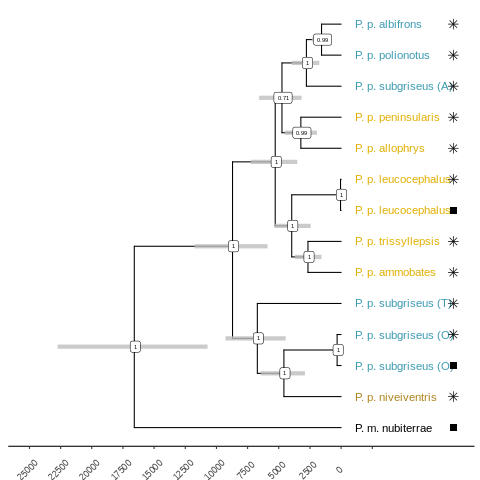

In [131]:
%%R
# read.beast comes from treeio package
annot = read.beast('/n/hoekstra_lab_tier1/Users/brock/polionotus/phylo/snapp/highcov_n2.tre')
p = ggtree(annot) %<+% pop_map +
    geom_tiplab(aes(color=group,label=sciname),size=4,offset=0.0010) +
    scale_color_manual(values = c("#AF841C", wes_palette("Zissou1")[c(4,1)],"black")) +
    theme_tree2()
p = revts(p)
p = ggtree::rotate(p,24)
p = ggtree::rotate(p,25)
p = ggtree::rotate(p,26)
p = p + scale_x_continuous(labels = c(seq(0.0025*10,0,-0.0025)*1e6,""), # Values are in mYa, so I rescale here
                           breaks = seq(-0.0025*10,0.0025*1,0.0025),
                           limits =  c(-0.0025*10,0.0025*3+0.0015))

other_df = p$data %>% dplyr::select(parent,node,label,height_0.95_HPD,x,y)
other_df %<>% mutate(right_bound = height_0.95_HPD %>% purrr::map(`[`,1) %>% unlist, left_bound = height_0.95_HPD %>%  purrr::map(`[`,2) %>% unlist)
other_df %<>% filter(is.na(label))
pointdata = p$data %>% dplyr::select(label,seq,x,y) %>% filter(!is.na(label)) %>% mutate(x=0.009)

p = p + 
    ## ADD CONFIDENCE INTERVALS FOR ANCESTORS
    geom_segment(data = other_df, aes(x=-right_bound,xend=-left_bound,y=y,yend=y),color="gray",size=2,alpha=0.8) +
    ## ADD BOOTSTRAP SUPPORT
    geom_nodelab(aes(label=round(posterior, 2)),size=2,geom="label") +
    ## ADD WGS/SEQ SYMBOL ANNOTATIONS
    geom_point(data = pointdata, aes(x=x,y=y,shape=seq),size=3) +
    scale_shape_manual(values=c(8,15)) +
    theme(panel.background = element_rect(fill = "transparent",colour = NA),
          plot.background = element_rect(fill = "transparent",colour = NA),
         axis.text.x = element_text(angle=45,vjust=0.1)) +
    guides(color=F,shape=F)

p 

#ggsave('~/temp/polionotus/RAWFIGS/timetree.svg',p,width=6,height=4,bg="transparent")
#dev.off()


Trace file

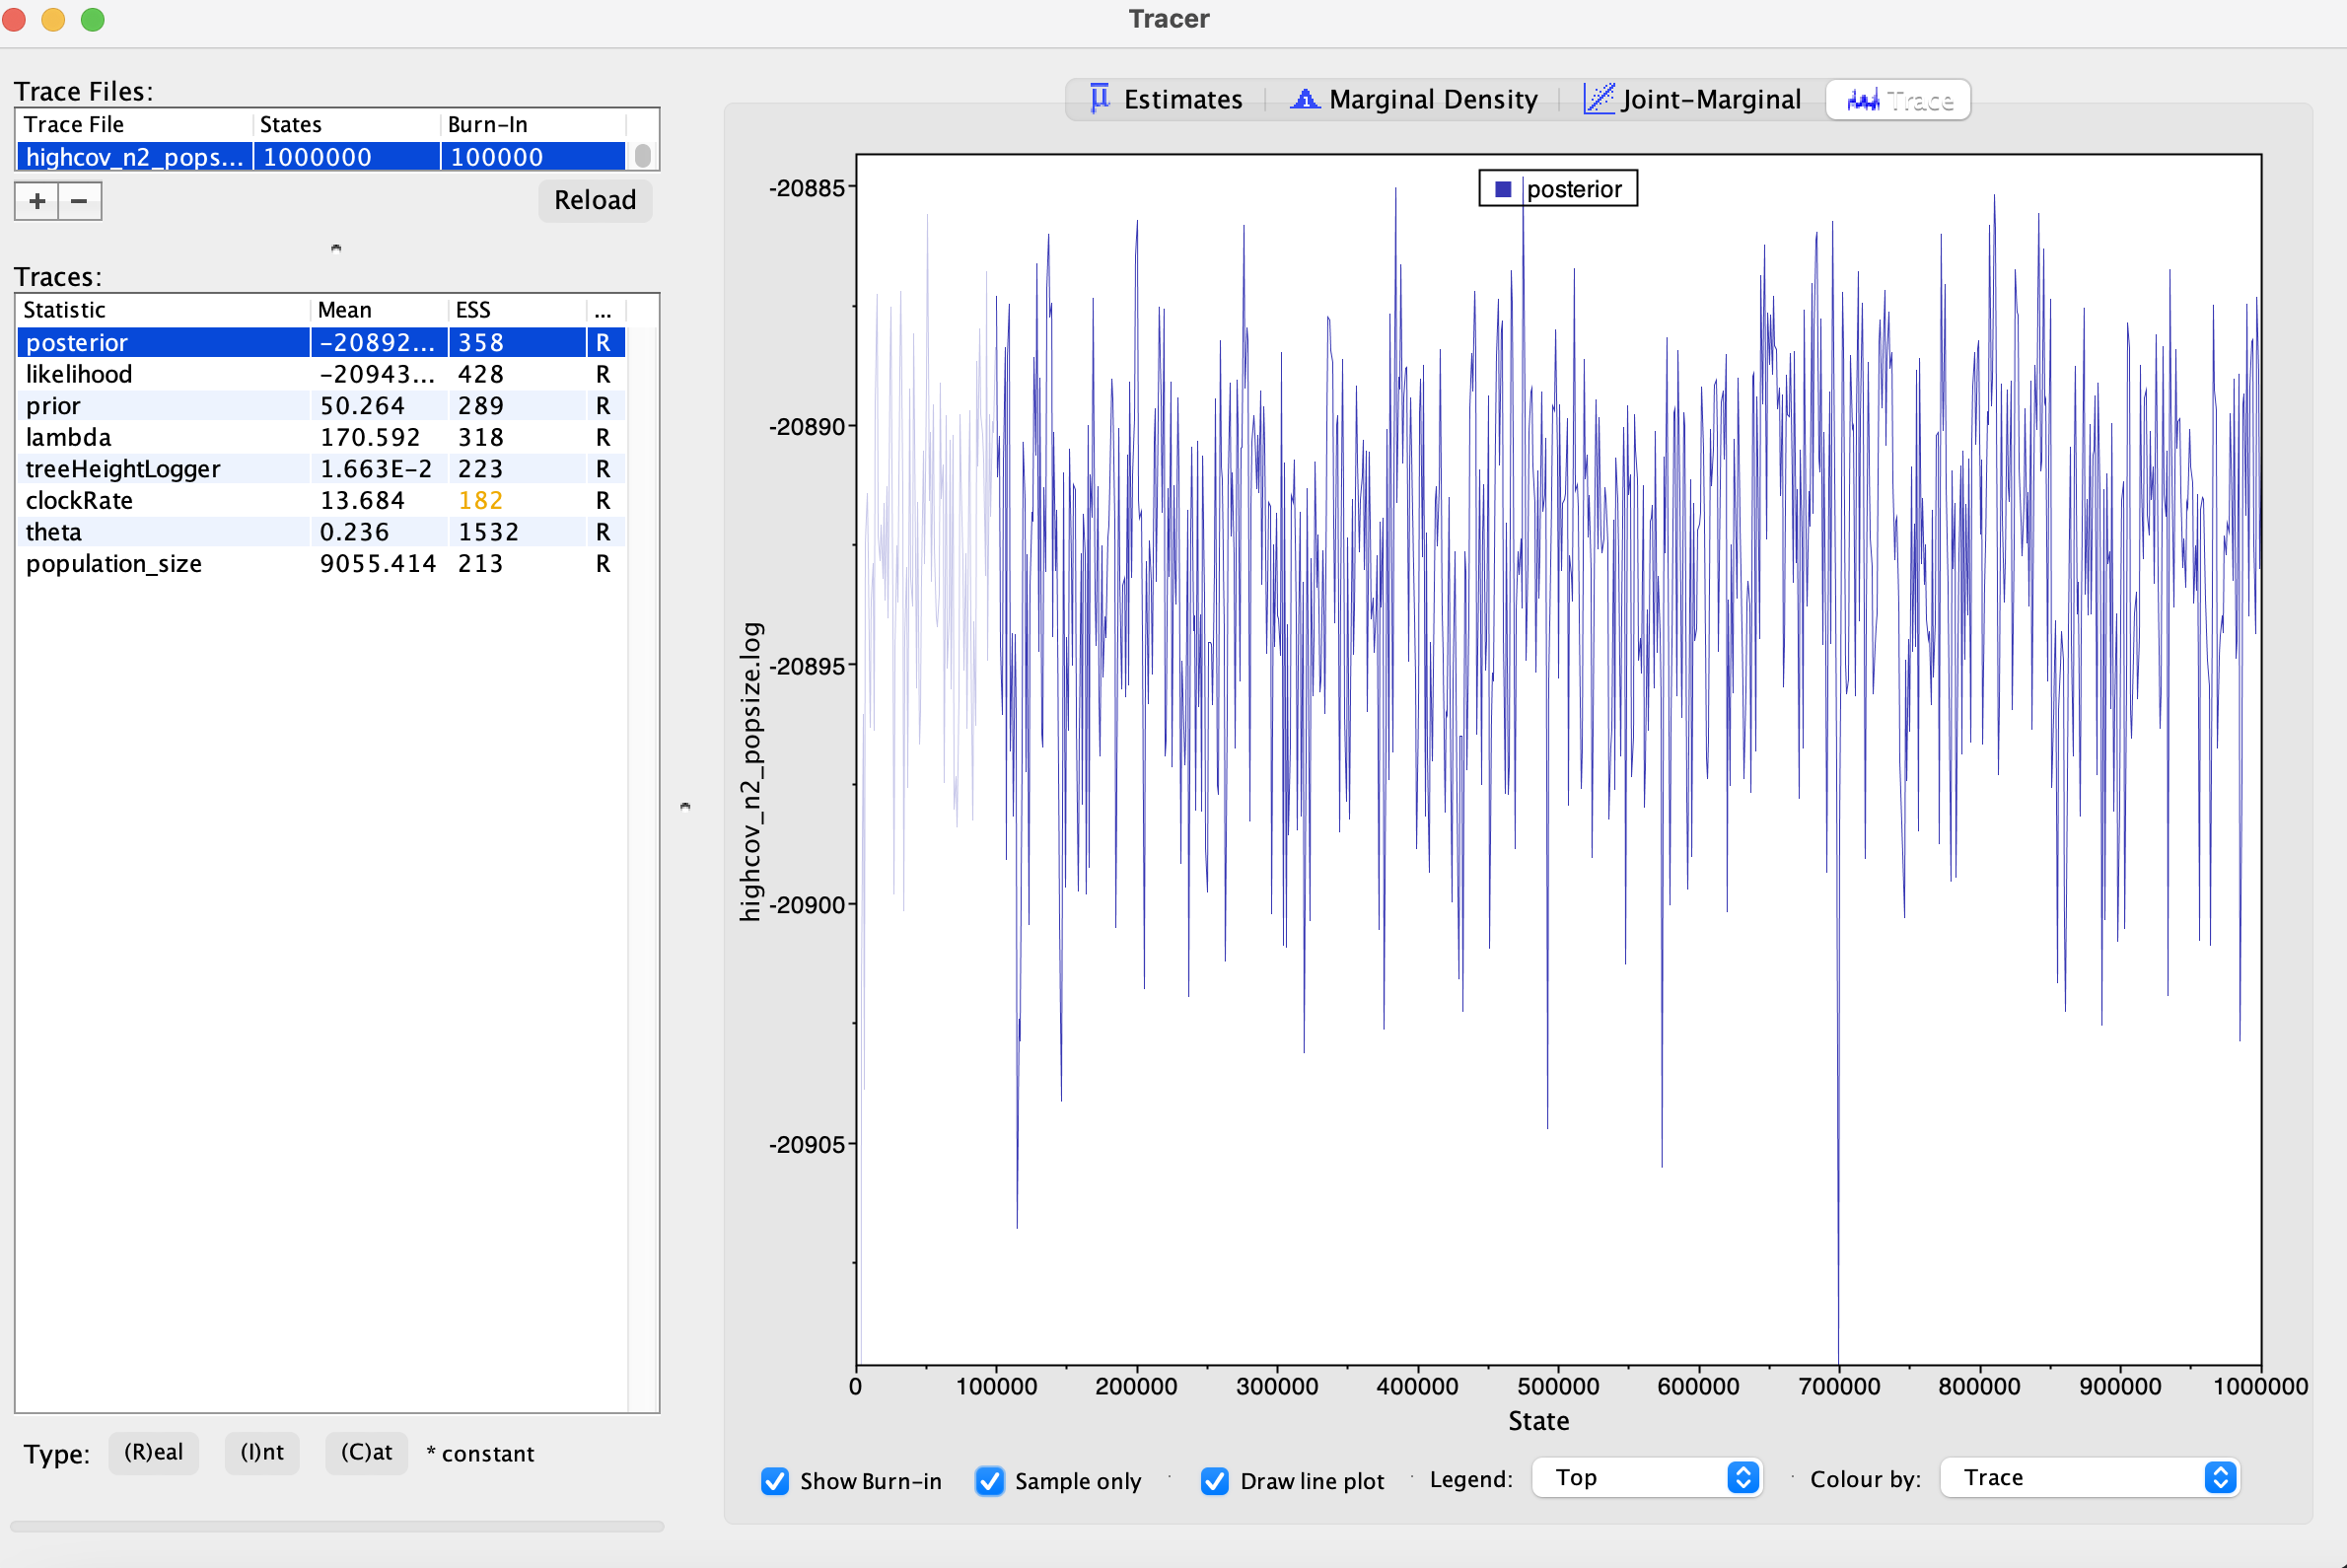

Densitree

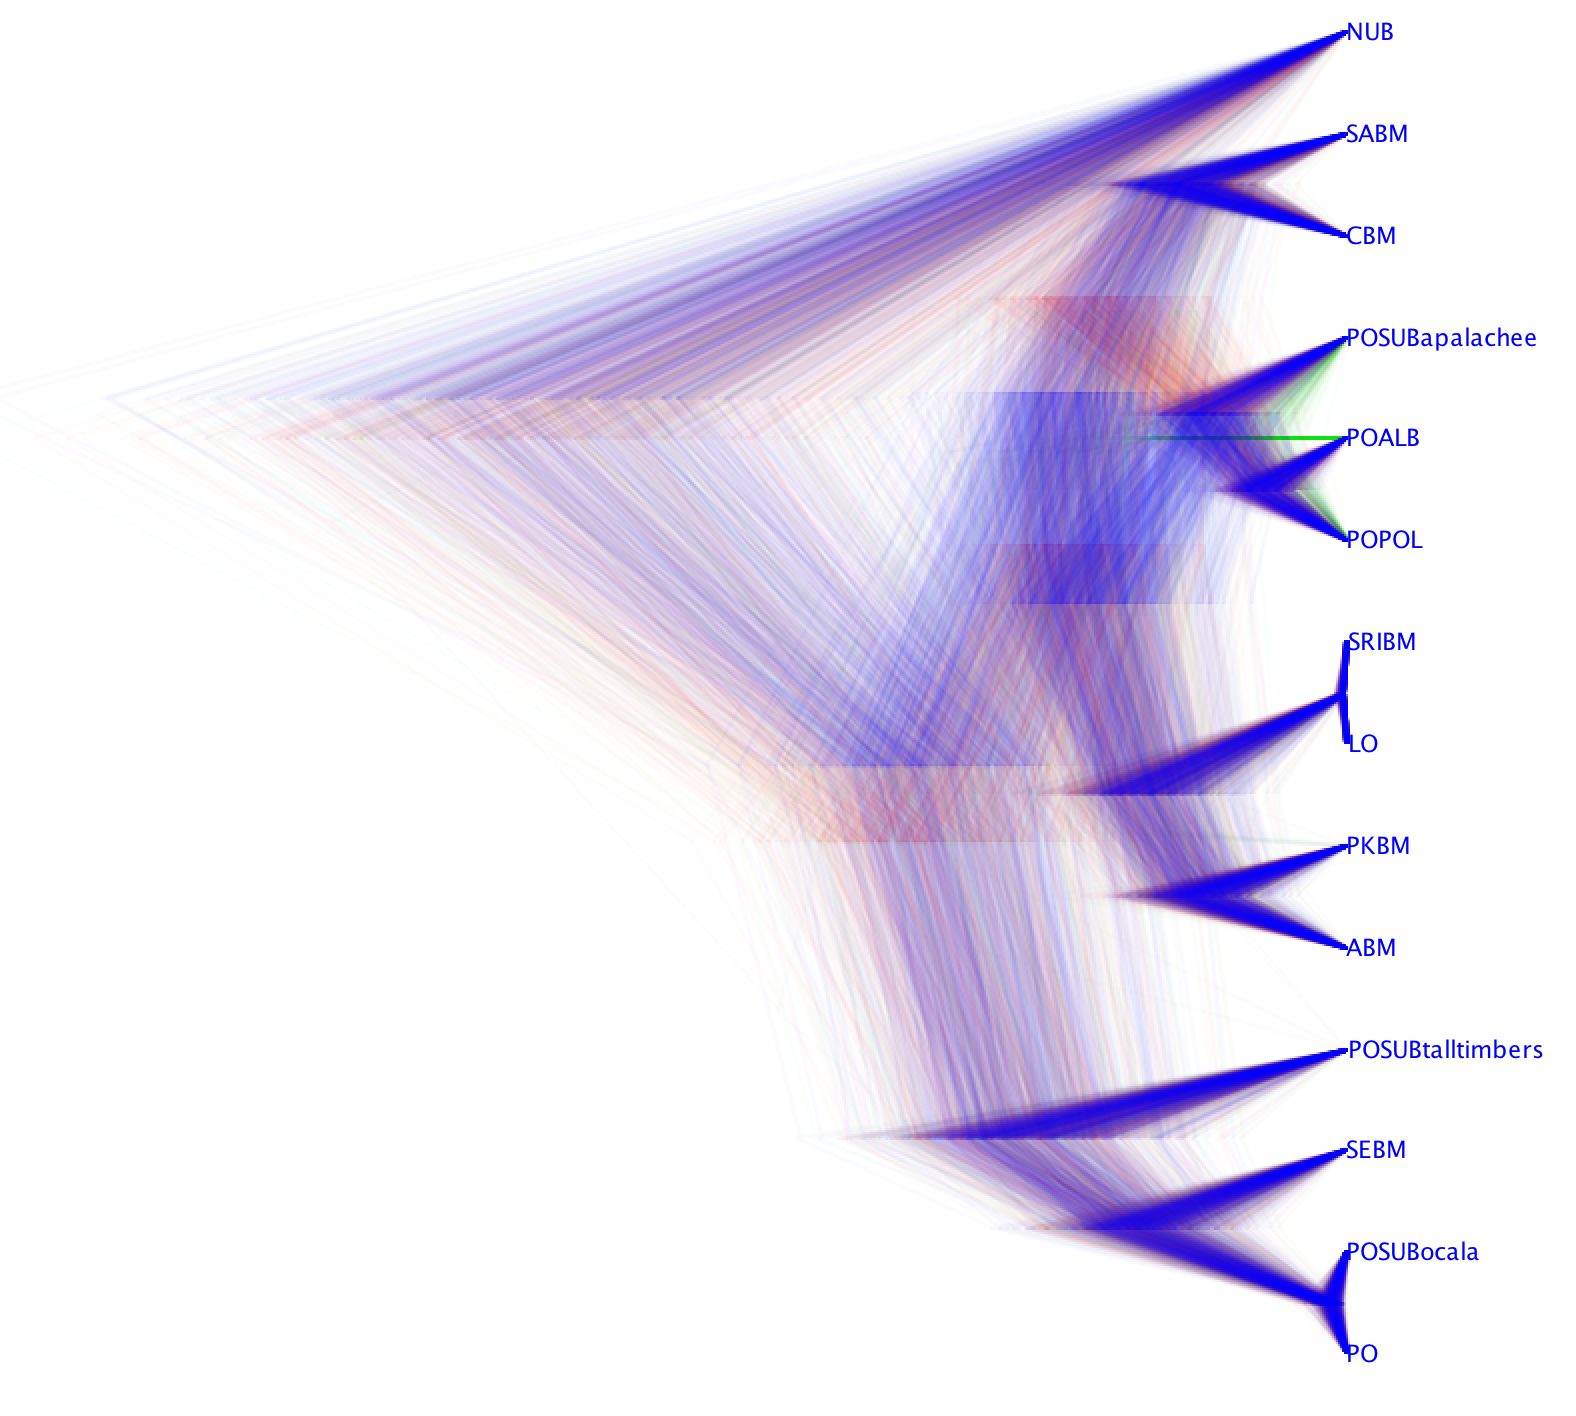

# Saguaro

Get sample coverage (has probably already been done already), which will be a useful metric for selecting a subset of samples to analyze

In [6]:
%%bash
module load vcftools
vcftools --gzvcf ../popgen_vcfs/vars/ALL.vcf.gz --depth --stdout > vcf_depth.txt


VCFtools - 0.1.15
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf ../popgen_vcfs/vars/ALL.vcf.gz
	--depth
	--stdout

Using zlib version: 1.2.7
After filtering, kept 297 out of 297 Individuals
Outputting Mean Depth by Individual
After filtering, kept 44850 out of a possible 44850 Sites
Run Time = 5.00 seconds


Select individuals to represent each population. There are several schemes to do this, most based on coverage. One such approach is below, which takes the top 2 individuals representing each population

In [34]:
%%bash
for pop in {ABM,PKBM,LO,CBM,SABM,POALB,PO,POSUB_A,POSUB_T,POSUB_O,POPOL,SEBM};do awk -v var=$pop '($2 == var) {print $1}' ../poplists/wgs_seq_pops.txt | while read ID;do grep "\<$ID\>" vcf_depth.txt;done | sort -nrk 3 | head -n 4 | awk '{print $1}';done > highest_cov_n2.txt

Below, I'm filtering for the agouti region using the 9845301 poplist

In [16]:
!mkdir -p saguaro
!mkdir -p saguaro/vcfs
for gene in ['agouti']:
    maf_filter = ('''module load bcftools;module load vcftools\n'''
                  # Grab biallelic SNPS with MAF > 0.025
                  '''bcftools view -R ../beds/{gene}_cov_bounds.txt -S <(cut -f1 ../poplists/9845301_top2n_bypop.txt) -i \'ALT !~ "*"  && STRLEN(REF) == 1 && TYPE="snp"\' -M2 --min-ac 1 -q 0.025:minor '''
                  '''-O v ../popgen_vcfs/vars/ALL.vcf.gz > saguaro/vcfs/{gene}.maf.snps.vcf \n''').format(gene=gene)
    slurm = make_slurm(run=True,id='%s.maf' % gene,cmd_string=maf_filter,mem='1000',time='00:10:00')

Submitted batch job 66593229


Then I take the VCF and convert it to a format that works for Saguaro

In [17]:
!mkdir -p saguaro/hmms
for gene in ['agouti']:
    vcf2HMM = ('''/n/home11/twooldridge/Software/saguarogw-code-44/VCF2HMMFeature '''
               '''-i saguaro/vcfs/{gene}.maf.snps.vcf '''
               '''-o saguaro/hmms/{gene}.hmm '''
               '''-nosame ''').format(gene=gene)
    slurm = make_slurm(id='%s.vcf2HMM' % gene,cmd_string=vcf2HMM,mem='1000',time='00:01:00',run=True)

Submitted batch job 66593246


And this is where I actually run saguaro. For a small # of individuals and a region the size of agouti, it really doesn't take too long (< 5 min)

In [18]:
!mkdir -p saguaro/cacti
for gene in ['agouti']:
    !mkdir -p saguaro/cacti/$gene
    cmd=('/n/home11/twooldridge/Software/saguarogw-code-44/Saguaro -f saguaro/hmms/{gene}.hmm -o saguaro/cacti/{gene}').format(gene=gene)
    slurm = make_slurm(run=True,id='saguaro.%s' % gene,cmd_string=cmd,mem='5000',time='00:30:00')
        

Submitted batch job 66593268


Now that saguaro is done running, I can create phylip files for each cactus that can be easily read and plotted in R

In [19]:
for gene in ['agouti']:
    outdir = 'saguaro/cacti/%s' % gene
    cmd=('''cd {outdir};mkdir -p phylip\n'''
         '''/n/home11/twooldridge/Software/saguarogw-code-44/Saguaro2Phylip -i saguaro.cactus\n'''
         '''mv cactus* phylip/\n'''
         '''cd -''').format(outdir=outdir)
    !$cmd

/n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/phylo


I also reformat the classification file (LocalTrees.out) for easy parsing and analysis in R

In [20]:
for gene in ['agouti']:
    outdir = 'saguaro/cacti/%s' % gene
    awk_string = "awk '{OFS=\"\\t\"} {print $2,$3,$5,$7,$1,$NF}'"
    sed_string = "sed 's/://g'"
    cmd=('''cd {outdir}\n'''
         '''grep "cactus" LocalTrees.out | grep -iv "adding" > local_classification.bed\n'''
         '''{awk_string} local_classification.bed | {sed_string} | sponge local_classification.bed\n'''
         '''cd -''').format(outdir=outdir,awk_string=awk_string,sed_string=sed_string)
    slurm = make_slurm(run=True,id='%s.grabtrees' % chrom,cmd_string=cmd,mem='5000',time='00:20:00')

Submitted batch job 66593301


## Visualization

### Classification across Agouti

Rough visualization

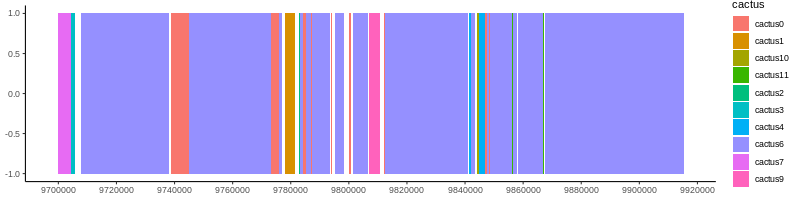

In [7]:
%%R -w 800 -h 200
acacti = 
fread('/n/hoekstra_lab_tier1/Users/brock/polionotus/phylo/saguaro/cacti/agouti/local_classification.bed') %>%
set_colnames(c("chr","start","end","length","cactus","likelihood"))

p = ggplot(acacti) +
    # Need to specify ggplot2::geom_rect if ggbio is loaded, otherwise you get:
    # Error: Can't add `o` to a ggplot object
    ggplot2::geom_rect(aes(xmin=start,xmax=end,ymin=-1,ymax=1,fill=cactus)) +
    theme_classic() +
    scale_x_continuous(breaks=scales::pretty_breaks(n=10)) +
    theme_classic()
p

For Fig. 5C<br>I end up cleaning things up (e.g. isoforms, gene names) in illustratot because ggbio is a pain to work with, and it's just easier that way

[1] "Writing output to/tmp/RtmpPjnkB4/file79151087dc73"
[1] "Running command: bedtools subtract -a /n/hoekstra_lab_tier1/Users/brock/polionotus/phylo/tmp/file79151214c649 -b /n/hoekstra_lab_tier1/Users/brock/polionotus/phylo/tmp/file791552ee7b11 > /tmp/RtmpPjnkB4/file79151087dc73"


R[write to console]: Parsing transcripts...

R[write to console]: Parsing exons...

R[write to console]: Parsing cds...

R[write to console]: Parsing utrs...

R[write to console]: ------exons...

R[write to console]: ------cdss...

R[write to console]: ------introns...

R[write to console]: ------utr...

R[write to console]: aggregating...

R[write to console]: Done

R[write to console]: Constructing graphics...

R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

R[write to console]: Parsing transcripts...

R[write to console]: Parsing exons...

R[write to console]: Parsing cds...

R[write to console]: Parsing utrs...

R[write to console]: ------exons...

R[write to console]: ------cdss...

R[write to console]: ------introns...

R[write to console]: ------utr...

R[write to console]: aggregating...

R[write to console]: Done

R[write to console]: Constructing graphics...



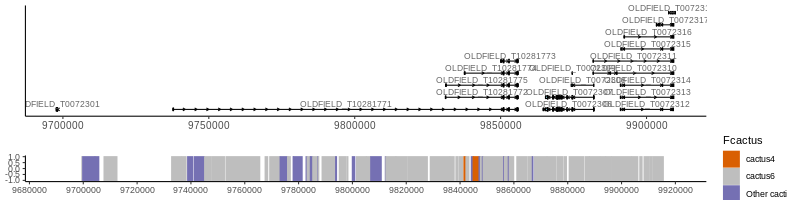

In [181]:
%%R -w 800 -h 200

asm = fread('/n/hoekstra_lab_tier1/Users/brock/polionotus/masks/assembly_gaps.bed') %>% set_colnames(c("chr","start","end"))
acacti_filtered = runBedCmd(acacti, asm, 'bedtools subtract')
acacti_filtered %<>% set_colnames(c("chr","start","end","length","cactus","likelihood"))
acacti_filtered %<>% mutate(Fcactus = cactus, Fcactus = ifelse(!Fcactus %in% c("cactus6","cactus4"),"Other cacti",Fcactus))

visbuffer = 5e2
gene_chrom = as.character(agouti$chr)
gene_start = agouti$start
gene_end = agouti$end


saguaro = 
    ggplot(acacti_filtered) +
    # Need to specify ggplot2::geom_rect if ggbio is loaded, otherwise you get:
    # Error: Can't add `o` to a ggplot object
    ggplot2::geom_rect(aes(xmin=start, xmax=end, ymin=-1, ymax=1, fill=Fcactus, color = Fcactus)) +
    scale_fill_manual(values = c('#d95f02','gray','#7570b3')) +
    scale_color_manual(values = c('#d95f02','gray','#7570b3')) +
    theme_classic() +
    scale_x_continuous(breaks=scales::pretty_breaks(n=10)) +
    xlim(c(9.69e6,9.92e6)) +
    theme_classic()


breaks=scales::pretty_breaks(n=6)
genes = 
    ggbio::autoplot(txdb, 
             which=makeGRangesFromDataFrame(data.frame(chr=gene_chrom,start = gene_start, end = gene_end)),
             utr.rect.h=0.1,
             exon.rect.h = 0.1,
             cds.rect.h = 0.15,
             #mode="reduce",
             #stat="reduce",
             color="black",
             fill=wes_palette("Zissou1")[2],
             alpha=1) + 
    #ggplot2::geom_rect(data = acacti_filtered, aes(xmin=start,xmax=end,ymin=-Inf,ymax=0.8,fill=Fcactus, color = Fcactus)) +
    #scale_fill_manual(values = c('#d95f02','gray','#7570b3')) +
    #scale_color_manual(values = c('#d95f02','gray','#7570b3')) +
    ylim(c(-1,10)) +
    xlim(c(9.69e6,9.92e6)) +
    theme_classic() +
    theme(legend.position="bottom", axis.text.x = element_text(size=10), axis.text.y = element_blank(),axis.ticks.y = element_blank(),plot.title = element_text(hjust=0.5)) +
    scale_x_continuous(breaks = pretty_breaks(n=6))  +
    guides(fill = guide_legend(nrow=1,keywidth = 0.5,keyheight = 0.25, label.position="right")) 

#genes
plot_grid(genes@ggplot, saguaro, ncol=1, align = "v", axis = "lr", rel_heights = c(3,1), label_size = 4)
#ggsave('~/temp/polionotus/saguarogeneplot.svg', width=6, height=6)

### Visualization of cacti

Read in cacti, reroot with NUB (P. maniculatus nubiterrae) outgroup

In [26]:
%%R
treepaths = list.files('/n/hoekstra_lab_tier1/Users/brock/polionotus/phylo/saguaro/cacti/agouti/phylip',pattern = 'cactus',full.names=TRUE)
trees = lapply(treepaths,function(treepath){nj(phangorn::readDist(treepath))});
names(trees) = lapply(treepaths,basename)

edgeReroot = function(tree, taxon = NA){
    if (is.na(taxon)){
        stop('no taxon specified for new root!')
    }
    NUM = which(tree$tip.label == taxon)
    rooted = phytools::reroot(tree, NUM, position = 0.5 * tree$edge.length[which(tree$edge[,2] == NUM)])
    return(rooted)
}
rooted_trees = lapply(trees, function(tree){edgeReroot(tree, taxon = '01_NB_F_E')})
names(rooted_trees) = names(trees)


# The NJ algorithm sometiomes generates negative branch lengths. 
# For now, I set these to zero (http://boopsboops.blogspot.com/2010/10/negative-branch-lengths-in-neighbour.html),
# but I'm not sure if this is the right approach. Regardless, the topology doesn't change and the result is the same

rooted_trees = lapply(rooted_trees, function(tree){tree$edge.length[tree$edge.length < 0] = 0; return(tree)})
names(rooted_trees) = names(trees)

Get metadata for annotating tree

In [29]:
%%R
pop_map = read.table('/n/hoekstra_lab_tier1/Users/brock/polionotus/polionotus_pop_data.csv',sep=",",header=T)
pop_map %<>% 
    mutate(group = NA) %>%
    mutate(group = ifelse(grepl("PO",pop),"Mainland",group),
           group = ifelse(pop == "SEBM","Atlantic Beach",group),
           group = ifelse(pop == "POALB","P. p. albifrons",group),
           group = ifelse(is.na(group), "Gulf Beach",group),
           group = ifelse(pop == "NUB","Outgroup",group))

pop_map %<>% mutate(seq = ifelse(pop %in% c('PO','LO','NUB'),'WGS','CAP'))

genotypes = read.table('/n/hoekstra_lab_tier1/Users/brock/polionotus/pigmentation//9845301_genotypes.txt') %>% set_colnames(c("ID","POP","GENOTYPE"))
meta = left_join(ID_POP_MAP,genotypes) %>% dplyr::select(!group)
meta = left_join(meta,pop_map %>% dplyr::select(altlabel,sciname,group),by=c('POP'='altlabel'))
meta$GENOTYPE = factor(meta$GENOTYPE)
meta %<>% mutate(trunclabels = str_trunc(ID,9,side="right",ellipsis = ""))
meta = inner_join(meta,data.frame(rooted_trees[[1]]$tip.label) %>% set_colnames(c("tiplabels")),by = c("trunclabels"="tiplabels")) %>% distinct %>% dplyr::select(trunclabels,POP,sciname,group,GENOTYPE)

Joining, by = c("ID", "POP")


Population tree (left tree Fig. 5)

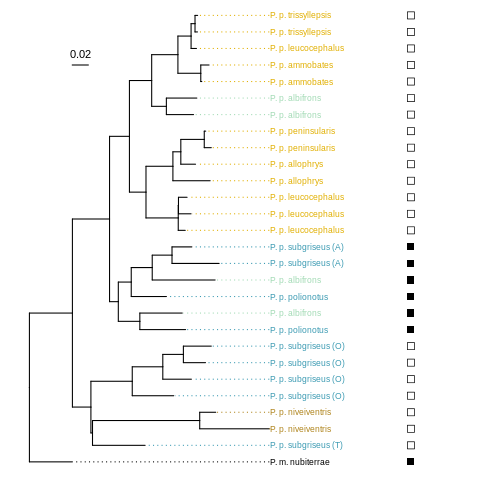

In [30]:
%%R
p = ggtree(rooted_trees[["cactus6"]]) %<+% 
    meta +
    geom_tiplab(aes(color=group, label = sciname),size=3,align=T) +
    geom_tippoint(aes(shape=GENOTYPE, x = 0.45),size=3) +
    geom_treescale(x = 0.05, y = 25) +
    scale_color_manual(values = c("#AF841C", wes_palette("Zissou1")[c(4,1)],"black","#a1dab4")) +
    scale_shape_manual(values=c(0,15)) +
    theme(legend.position="none") +
    xlim(c(0,0.5))
#p = ggtree::rotate(p,31)
#p = ggtree::rotate(p,36)
p

#ggsave('~/temp/polionotus/RAWFIGS/population_cactus.svg',width=4,height=6)

Regulatory locus tree (right tree Fig. 5)

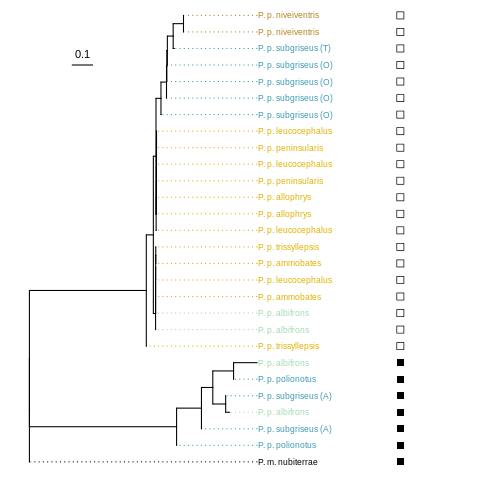

In [31]:
%%R
ggtree(rooted_trees[["cactus4"]]) %<+% 
    meta +
    geom_tiplab(aes(color=group, label = sciname),size=3,align=T) +
    geom_tippoint(aes(shape=GENOTYPE, x = 1.75),size=3) +
    geom_treescale(x = 0.2, y = 25) +
    scale_color_manual(values = c("#AF841C", wes_palette("Zissou1")[c(4,1)],"black","#a1dab4")) +
    scale_shape_manual(values=c(0,15)) +
    theme(legend.position="none") +
    xlim(c(0,2))
#ggsave('~/temp/polionotus/RAWFIGS/regulatory_cactus.svg',width=4,height=6)